In [18]:
import cv2

import random
import math

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchinfo
from torch.utils.tensorboard import SummaryWriter

from IPython.display import Image

import time

loss_diagram = SummaryWriter()

In [2]:
#generating samples

def generate_points(center, radius, number):

    points = []

    for i in range(number):

        r = radius * math.sqrt(random.random())
        theta = random.uniform(0, 2 * math.pi)

        x = int(center[0] + r * math.cos(theta))
        y = int(center[1] + r * math.sin(theta))

        points.append((x, y))

    return points

def points_far_enough(points, min_distance):

    for i in range(len(points) - 1):
        for j in range(i + 1, len(points)):

            distance = math.hypot(points[i][0] - points[j][0], points[i][1] - points[j][1])

            if (distance < min_distance):
                return False
                
    return True

# https://docs.opencv.org/3.4/de/d25/imgproc_color_conversions.html
def lum(color):
    return (0.299 * color[0] + 0.587 * color[1] + 0.114 * color[2])

def generate_shape_color(bg_color, number, luminance_difference):

    # luminance_difference = 20 # 100
    checking_prev_colors = 4
    
    colors = []

    color_generated = True

    while True:

        new_color = tuple(random.randint(0, 255) for i in range(3))

        #check if bg_color and new_color have sufficiently different luminances
        if (abs(lum(bg_color) - lum(new_color)) >= luminance_difference):

            #check if new color and every color in colors[] have sufficiently different luminances
            # this needs to be calculated based on neighboring colors, otherwise it cant find a suitable color

            if (len(colors) >= checking_prev_colors):

                if (abs(lum(colors[len(colors) - 1]) - lum(new_color)) < luminance_difference
                   or abs(lum(colors[len(colors) - 3]) - lum(new_color)) < luminance_difference):
                    color_generated = False
            
            else:
                for color in colors:
                    if (abs(lum(color) - lum(new_color)) < luminance_difference):
                        color_generated = False

            if (color_generated == False):
                color_generated = True
                continue
            
            colors.append(new_color)

        if (len(colors) == number):
            return colors

def add_noise(img):
    
    noise = np.random.normal(0, 6, img.shape).astype(np.float32)
    
    noisy_image = img.astype(np.float32) + cv2.GaussianBlur(noise, (7, 7), sigmaX=0)
    
    # Clip values to valid range [0, 255] and convert back to uint8
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
    
    return noisy_image


def apply_h(img, points):

    height_half = len(img) // 2
    width_half = len(img[0]) // 2

    point_distance = 10

    x = random.randint(point_distance, width_half - point_distance)
    y = random.randint(point_distance, height_half - point_distance)

    rect = np.array([[x, y], [x + width_half, y], [x + width_half, y + height_half], [x, y + height_half]])
    
    #4 kotičke okna pomaknemo za naključne pomike v intervalu [-16, 16]
    
    rect_prim = np.array([[rect[0][0] + random.randint(-16, 16), rect[0][1] + random.randint(-16, 16)], 
                 [rect[1][0] + random.randint(-16, 16), rect[1][1] + random.randint(-16, 16)], 
                 [rect[2][0] + random.randint(-16, 16), rect[2][1] + random.randint(-16, 16)], 
                 [rect[3][0] + random.randint(-16, 16), rect[3][1] + random.randint(-16, 16)]], np.int32)

    shift = random.randint(0, 3)
    rect_prim = np.roll(rect_prim, shift, axis=-1)
    
    #iz 4 kotičkov in njihovih pomikov izračunamo homografijo H
    H, _ = cv2.findHomography(rect, rect_prim)

    H = np.linalg.inv(H)

    #inverz ocenjene homografije H^-1 apliciramo na sliko, dobimo transformirano sliko
    warped_image = cv2.warpPerspective(img, H, (img.shape[1], img.shape[0]), borderMode=cv2.BORDER_REPLICATE)
    
    #project points
    
    # Convert to numpy array in shape (H, W, 2)
    points = np.array(points)
    
    # Flatten to shape (H*W, 2)
    flat_points = points.reshape(-1, 2)
    
    # Add homogeneous coordinate (x, y) -> (x, y, 1)
    ones = np.ones((flat_points.shape[0], 1))
    points_homogeneous = np.hstack([flat_points, ones])  # shape (N, 3)

    # Apply homography
    projected = H @ points_homogeneous.T  # shape (3, N)
    projected = projected.T               # shape (N, 3)

    # Convert back to 2D
    transformed_points = projected[:, :2] / projected[:, 2:3]

    # Reshape to original shape (rows, cols, 2)
    transformed_array = transformed_points.reshape(points.shape)
    
    h_points_img = np.zeros(img.shape, dtype=np.float64)

    if transformed_array.ndim == 2:
        for point in transformed_array:
            cv2.circle(h_points_img, (int(point[0]), int(point[1])), 1, 1, -1)
    else:
    
        for line in transformed_array:
            for point in line:
                cv2.circle(h_points_img, (int(point[0]), int(point[1])), 1, 1, -1)

    return warped_image, h_points_img 

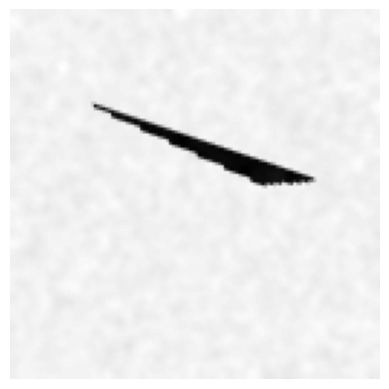

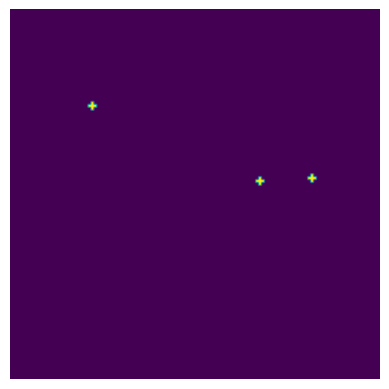

In [3]:
def generate_triangle(width, height):

    center = (width // 2, height // 2)
    radius = width // 2 - 5 #staying within bounds
    min_distance = 10

    while True:
        points = generate_points(center, radius, 3)
        
        if points_far_enough(points, min_distance):
            break

    background_color = tuple(random.randint(0, 255) for i in range(3))
    
    img = np.full((height, width, 3), background_color, dtype=np.uint8)

    pts_array = np.array([points], dtype=np.int32)
    cv2.fillPoly(img, pts_array, color=generate_shape_color(background_color, 1, 100)[0])

    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    final_img, points_img = apply_h(img_gray, points)
    final_img = add_noise(final_img)

    # #build the points image
    # points_img = np.zeros(img.shape)
    
    # for point in points:
    #     cv2.circle(points_img, point, 1, (0, 255, 0), -1)

    return final_img, points_img

for i in range(1):
    image, points_image = generate_triangle(128, 128)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()
    
    plt.imshow(points_image)
    plt.axis('off')
    plt.show()

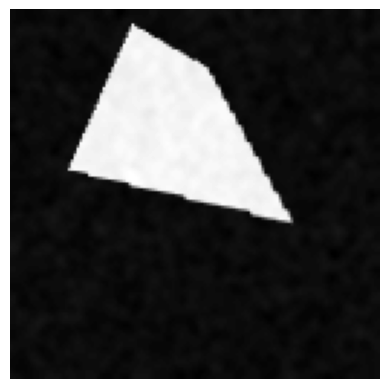

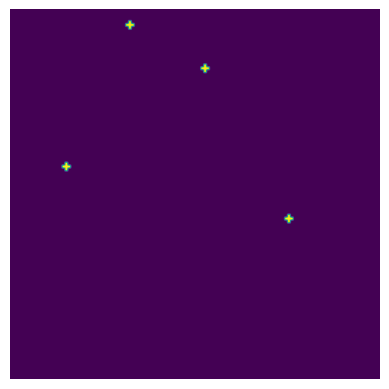

In [4]:
# https://stackoverflow.com/questions/9608148/python-script-to-determine-if-x-y-coordinates-are-colinear-getting-some-e
def colinear_points(points):
    # check if any 3 of the generated points are colinear (prevents generating triangle)
    
    for i in range(4):
        x1, y1 = points[i % 4]
        x2, y2 = points[(i + 1) % 4]
        x3, y3 = points[(i + 2) % 4]

        if (abs(((x1 * (y2 - y3)) + (x2 * (y3 - y1) + (x3 * (y1 - y2)))) / 2.0) < 1e-2):
            return True

    return False
    
# https://stackoverflow.com/questions/18583214/calculate-angle-of-triangle-python
def check_angles(points):
    # prevents square overlapping itself and colinearity

    angle_min = 10

    for i in range(4):
        x1, y1 = points[i % 4]
        x2, y2 = points[(i + 1) % 4]
        x3, y3 = points[(i + 2) % 4]

        dx1 = x1 - x2
        dy1 = y1 - y2

        dx2 = x3 - x2
        dy2 = y3 - y2

        numerator = dx1 * dx2 + dy1 * dy2
        denominator = math.sqrt((math.pow(dx1, 2) + math.pow(dy1, 2)) * (math.pow(dx2, 2) + math.pow(dy2, 2)))

        angle = abs(180 - math.degrees(math.acos(numerator / denominator)))

        if (angle < angle_min):
            return False

    return True

#https://stackoverflow.com/questions/3838329/how-can-i-check-if-two-segments-intersect
def ccw(p1, p2, p3):
    return (p3[1] - p1[1]) * (p2[0] - p1[0]) > (p2[1] - p1[1]) * (p3[0] - p1[0])

def is_valid_square(points):
    return ((ccw(points[0], points[1], points[3]) != ccw(points[2], points[1], points[3]) 
                 and ccw(points[0], points[2], points[1]) != ccw(points[0], points[2], points[3]))) 

def sort_by_angle(points, center):

    def angle(point):
        return math.atan2(point[1] - center[1], point[0] - center[0])

    return sorted(points, key=angle)


def generate_square(width, height):

    center = (width // 2, height // 2)
    radius = width // 2 - 5 #staying within bounds
    min_distance = 10

    while True:
        points = generate_points(center, radius, 4)
        points = sort_by_angle(points, center)
        
        if points_far_enough(points, min_distance) and is_valid_square(points) and check_angles(points) and not colinear_points(points):
            break

    background_color = tuple(random.randint(0, 255) for i in range(3))
    
    img = np.full((height, width, 3), background_color, dtype=np.uint8)

    pts_array = np.array([points], dtype=np.int32)
    cv2.fillPoly(img, pts_array, color=generate_shape_color(background_color, 1, 100)[0])

    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    final_img, points_img = apply_h(img_gray, points)
    final_img = add_noise(final_img)

    # points_img = np.zeros(img.shape)
    
    # for point in points:
    #     cv2.circle(points_img, point, 1, (0, 255, 0), -1)

    return final_img, points_img

for i in range(1):
    image, points_image = generate_square(128, 128)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

    plt.imshow(points_image)
    plt.axis('off')
    plt.show()

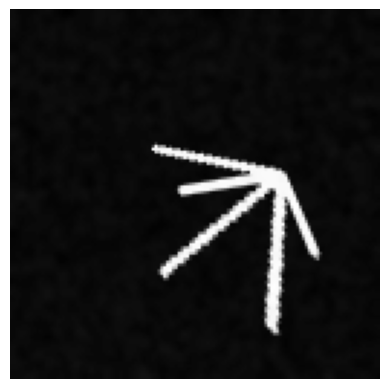

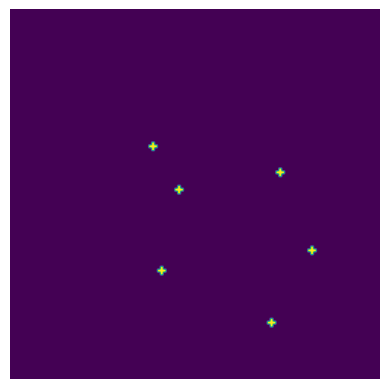

In [5]:
def check_angles_star(points, center_point):
    # prevents square overlapping itself and colinearity

    angle_min = 40
    
    for i in range(len(points) - 1):
        for j in range(i + 1, len(points)):
            x1, y1 = points[i]
            x2, y2 = points[j]
            x3, y3 = center_point
    
            dx1 = x1 - x2
            dy1 = y1 - y2
    
            dx2 = x3 - x2
            dy2 = y3 - y2
    
            numerator = dx1 * dx2 + dy1 * dy2
            denominator = math.sqrt((math.pow(dx1, 2) + math.pow(dy1, 2)) * (math.pow(dx2, 2) + math.pow(dy2, 2)))
    
            if (denominator == 0):
                return False
            
            angle = abs(180 - math.degrees(math.acos(numerator / denominator)))
    
            if (angle < angle_min):
                return False

    return True


def generate_star(width, height):

    center = (width // 2, height // 2)
    radius = width // 2 - 30
    min_distance = 15

    center_point = generate_points(center, radius, 1)
    
    while True:
        points = generate_points(center, radius, 5)
        
        if check_angles_star(points, center_point[0]):
            
            points.append(center_point[0])
            if points_far_enough(points, min_distance):
                break

    background_color = tuple(random.randint(0, 255) for i in range(3))
    
    img = np.full((height, width, 3), background_color, dtype=np.uint8)

    pts_array = np.array(points, dtype=np.int32)

    color = generate_shape_color(background_color, 1, 100)[0]
    
    for i in range(len(pts_array) - 1):
        cv2.line(img, pts_array[i], pts_array[len(pts_array) - 1], color=color, thickness=2)

    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    final_img, points_img = apply_h(img_gray, points)
    final_img = add_noise(final_img)
    
    # points_img = np.zeros(img.shape)
    
    # for point in points:
    #     cv2.circle(points_img, point, 1, (0, 255, 0), -1)

    return final_img, points_img


for i in range(1):
    image, points_image = generate_star(128, 128)
    
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

    plt.imshow(points_image)
    plt.axis('off')
    plt.show()

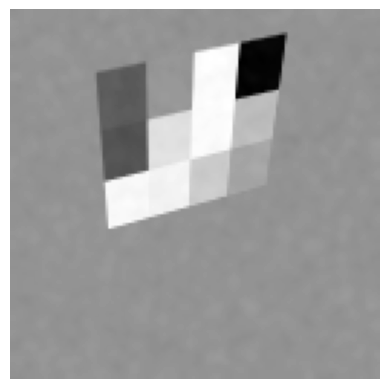

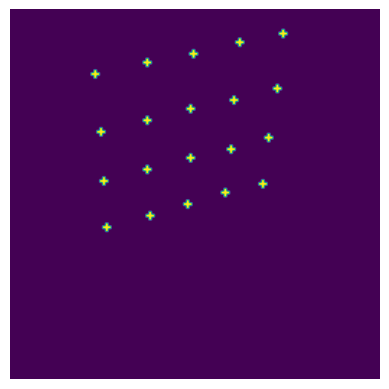

In [12]:
def generate_chessboard(width, height):
    rows = 3
    columns = 4

    square_dimension = width // 8
    
    center = (width // 2, height // 2)
    # radius = width // 2 - (square_dimension * rows // 2)
    radius = width // 2
    min_distance = 10

    while True:
    
        points = generate_points(center, radius, 1)

        if ((points[0][0] + (rows * square_dimension)) < width 
            and (points[0][1] + (columns * square_dimension)) < height):
            break
            
    matrix = [[points[0]]]

    for i in range(rows + 1):

        if (i > 0):
            matrix.append([(int(matrix[i - 1][0][0] + square_dimension), matrix[i - 1][0][1])])
        
        for j in range(1, columns + 1):

            matrix[i].append((matrix[i][j - 1][0], int(matrix[i][j - 1][1] + square_dimension)))
    
    background_color = tuple(random.randint(0, 255) for i in range(3))
    colors = generate_shape_color(background_color, rows * columns, 25)
    color_counter = 0
    
    img = np.full((height, width, 3), background_color, dtype=np.uint8)

    pts_array = []
    
    for i in range(len(matrix) - 1):

        for j in range(len(matrix[i]) - 1):
            
            pts_array.append(matrix[i][j])
            pts_array.append(matrix[i][j + 1])
            pts_array.append(matrix[i + 1][j + 1])
            pts_array.append(matrix[i + 1][j])

            cv2.fillPoly(img, np.array([pts_array]), color=colors[color_counter])
            color_counter += 1
            pts_array = []


    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    final_img, points_img = apply_h(img_gray, matrix)
    final_img = add_noise(final_img)

    #build the points image
    # points_img = np.zeros(img.shape)
    
    # for line in matrix:
    #     for point in line:
    #         cv2.circle(points_img, point, 1, (0, 255, 0), -1)

    return final_img, points_img

for i in range(1):
    image, points_image = generate_chessboard(128, 128)
        
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()
    
    plt.imshow(points_image)
    plt.axis('off')
    plt.show()

In [8]:
class ResnetBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels

        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1,  bias=False)
        self.conv3 = nn.Conv2d(in_channels, out_channels, 1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()

    def forward(self, x):
        
        output = self.conv1(x)
        output = self.bn1(output)
        output = self.relu1(output)
        output = self.conv2(output)
        output = self.bn2(output)

        if (self.in_channels != self.out_channels):
            
            tmp = self.conv3(x)
            output += tmp

        output = self.relu2(output)
                            
        return output


class Encoder(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.resnet1 = ResnetBlock(1, 64)
        self.resnet2 = ResnetBlock(64, 64)
        self.resnet3 = ResnetBlock(64, 64)
        self.resnet4 = ResnetBlock(64, 64)
        self.resnet5 = ResnetBlock(64, 128)
        self.resnet6 = ResnetBlock(128, 128)
        self.resnet7 = ResnetBlock(128, 128)
        self.resnet8 = ResnetBlock(128, 128)

        self.mp1 = nn.MaxPool2d(2, stride=2)
        self.mp2 = nn.MaxPool2d(2, stride=2)
        self.mp3 = nn.MaxPool2d(2, stride=2)
        self.mp4 = nn.MaxPool2d(2, stride=2)


    def forward(self, x):

        output = self.resnet1(x)
        output = self.resnet2(output)
        output = self.mp1(output)
        output = self.resnet3(output)
        output = self.resnet4(output)
        output = self.mp2(output)
        output = self.resnet5(output)
        output = self.resnet6(output)
        output = self.mp3(output)
        output = self.resnet7(output)
        output = self.resnet8(output)

        return output

class Decoder(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(128, 256, 3, padding=1, bias=False)
        self.conv2 = nn.Conv2d(256, 65, 1, bias=False) 

        self.bn1 = nn.BatchNorm2d(256)

        self.relu1 = nn.ReLU()

    def forward(self, x):

        output = self.conv1(x)
        output = self.bn1(output)
        
        output = self.relu1(output)
        
        output = self.conv2(output)

        return output

class Network(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.enc = Encoder()
        self.dec = Decoder()

    def forward(self, x):

        output = self.enc(x)
        output = self.dec(output)

        return output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Network().to(device)
torchinfo.summary(model, input_size=(1,1,256,256))

Layer (type:depth-idx)                   Output Shape              Param #
Network                                  [1, 65, 32, 32]           --
├─Encoder: 1-1                           [1, 128, 32, 32]          --
│    └─ResnetBlock: 2-1                  [1, 64, 256, 256]         --
│    │    └─Conv2d: 3-1                  [1, 64, 256, 256]         576
│    │    └─BatchNorm2d: 3-2             [1, 64, 256, 256]         128
│    │    └─ReLU: 3-3                    [1, 64, 256, 256]         --
│    │    └─Conv2d: 3-4                  [1, 64, 256, 256]         36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 256, 256]         128
│    │    └─Conv2d: 3-6                  [1, 64, 256, 256]         64
│    │    └─ReLU: 3-7                    [1, 64, 256, 256]         --
│    └─ResnetBlock: 2-2                  [1, 64, 256, 256]         4,096
│    │    └─Conv2d: 3-8                  [1, 64, 256, 256]         36,864
│    │    └─BatchNorm2d: 3-9             [1, 64, 256, 256]         128


In [9]:
#priprava ucnih primerov
def generate_batch(batch_size, width, height, device):

    images = []
    point_images = []
    
    for i in range(batch_size):

        #0 -> triangle; 1 -> square; 2 -> star; 3 -> checkerboard
        rand_img = random.randint(0, 3)

        if (rand_img == 0):
            img, points_img = generate_triangle(width, height)
        elif (rand_img == 1):
            img, points_img = generate_square(width, height)
        elif (rand_img == 2):
            img, points_img = generate_star(width, height)
        elif (rand_img == 3):
            img, points_img = generate_chessboard(width, height)

        img = torch.tensor(img).to(device).unsqueeze(0).to(torch.float32)
        points_img = torch.tensor(points_img).to(device).unsqueeze(0).to(torch.float32)

        #Reshape v velikost H/8, 8, W/8, 8
        points_img = torch.reshape(points_img, (height // 8, 8, width // 8, 8))
        
        #Permute kanalov v vrstni red H/8, W/8, 8, 8
        points_img = torch.permute(points_img, (0, 2, 1, 3))
        
        #Reshape v velikost H/8, W/8, 64
        points_img = torch.reshape(points_img, (height // 8, width // 8, 64))
        
        #Dodamo kanal 65
        points_img_new = torch.zeros((height // 8, width // 8, 1))
        points_img = torch.cat((points_img, points_img_new), 2)

        #Za vsak izmed H/8, 8, W/8 pikslov preverimo, da je nastavljena ena izmed 65 točk
        for j in range(len(points_img[0])):
            for k in range(len(points_img)):
                found_points = []

                for l in range(len(points_img[j][k])):
                    if (points_img[j][k][l] == 0):
                        found_points.append(l)

                if (len(found_points) == 0):
                   #kjer ni nastavljena nobena nastavimo kanal 65
                    points_img[j][k][64] = 1
                
                elif (len(found_points) > 1):
                    #kjer je nastavljenih več ohranimo eno naključno

                    keep_rand = random.randint(0, len(found_points) - 1)
                    
                    for l in range(len(found_points)):
                        if (keep_rand == l):
                            continue
                        
                        points_img[j][k][l] = 0

        points_img = torch.permute(points_img, (2, 0, 1))

        images.append(img)
        point_images.append(points_img)
        
    return torch.stack(images), torch.stack(point_images)


# generate_batch(1, 256, 256, device)

In [ ]:
iterations = 1000
batch_size = 8
epochs = 10

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), 1e-3)

steps_train = 0
steps_val = 0

for epoch in range(epochs):

    train_loss = 0
    val_loss = 0

    start_time = 0
    
    #train

    model.train()

    for iteration in range(iterations):

        start_time += time.time()
        
        images, point_images = generate_batch(batch_size, 128, 128, device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = loss_function(outputs, point_images)
    
        loss.backward()
        optimizer.step()
    
        train_loss += loss.item()
        loss_diagram.add_scalar("Loss/train/det", loss.item(), steps_train)
        steps_train += 1

        if (iteration % 100 == 0):
            print("Training iteration: ", iteration, " done! Time: ", str(time.time() - start_time))
            start_time = 0
    
    print("Epoch: ", str(epoch + 1), " (training). Loss: ", train_loss / iterations)

    #validate

    with torch.no_grad():
        model.eval()

        for iteration in range(iterations):

            start_time += time.time()
        
            images, point_images = generate_batch(batch_size, 128, 128, device)
            
            outputs = model(images)
            loss = loss_function(outputs, point_images)
    
            val_loss += loss.item()
            loss_diagram.add_scalar("Loss/test/det", loss.item(), steps_val)
            steps_val += 1

            if (iteration % 100 == 0):
                print("Validation iteration: ", iteration, " done! Time: ", str(time.time() - start_time))
                start_time = 0

    print("Epoch: ", str(epoch + 1), " (validating). Loss: ", val_loss / iterations)

    loss_diagram.flush()
    
    torch.save(model, ("save_detection_" + str(epoch) + ".pt"))

Training iteration:  0  done! Time:  5.2410008907318115
Training iteration:  100  done! Time:  -173079512030.58292
Training iteration:  200  done! Time:  -173079570394.1731
Training iteration:  300  done! Time:  -173079631711.09943
Training iteration:  400  done! Time:  -173079691457.3067
Training iteration:  500  done! Time:  -173079752508.44092
Training iteration:  600  done! Time:  -173079817424.25143
Training iteration:  700  done! Time:  -173079880196.91537
Training iteration:  800  done! Time:  -173079941897.06876
Training iteration:  900  done! Time:  -173080003801.46973
Epoch:  1  (training). Loss:  0.022416754144011064
Validation iteration:  0  done! Time:  -173080065544.73917
Validation iteration:  100  done! Time:  -173080121936.42792
Validation iteration:  200  done! Time:  -173080172342.16513
Validation iteration:  300  done! Time:  -173080222849.90054
Validation iteration:  400  done! Time:  -173080271040.94806
Validation iteration:  500  done! Time:  -173080317877.0041
V

In [ ]:
torch.save(model, "save_detection.pt")

In [29]:
def reshape_to_original_size():
    return

In [ ]:
# def find_point(p1, p2, center):
    
#     return (p1[0] + (center[0] - p2[0]), (p1[1] + (center[1] - p2[1])))

# def generate_cube(width, height):
    
#     center = (width // 2, height // 2)
#     radius = width // 2 - 50
#     min_distance = 30

#     center_point = generate_points(center, radius, 1)
    
#     while True:
#         points = generate_points(center, radius, 3)
        
#         if check_angles_star(points, center_point[0]):
            
#             points.append(center_point[0])
#             if points_far_enough(points, min_distance):
#                 break

#     sorted_points = sorted(points, key=lambda p: p[0])
#     # sorted_points = points
    
#     pts_array = []
    
#     # for i in range(len(sorted_points) - 1):
#     # for i in range(2):

#     #     square = [] 

#     #     square.append(sorted_points[i])
#     #     square.append(find_point(sorted_points[i], sorted_points[(i + 1) % 3], center_point[0]))
#     #     square.append(center_point[0])
#     #     square.append(sorted_points[(i + 1) % 3])
        
#     #     pts_array.append(square)

#     square = [] 

#     square.append(sorted_points[0])
#     square.append(find_point(sorted_points[0], sorted_points[1], center_point[0]))
#     square.append(center_point[0])
#     square.append(sorted_points[1])
    
#     pts_array.append(square)

#     square = [] 

#     square.append(sorted_points[1])
#     square.append(find_point(sorted_points[1], center_point[0], sorted_points[2]))
#     square.append(sorted_points[2])
#     square.append(center_point[0])

#     pts_array.append(square)

#     square = [] 

#     square.append(center_point[0])
#     square.append(find_point(center_point[0], sorted_points[2], sorted_points[0]))
#     square.append(sorted_points[2])
#     square.append(sorted_points[0])

#     pts_array.append(square)
    
    
#     print(center_point)
#     print(sorted_points)
#     print(pts_array)
    
#     background_color = tuple(random.randint(0, 255) for i in range(3))
#     colors = generate_shape_color(background_color, 3, 30)
#     color_counter = 0
    
#     img = np.full((width, height, 3), background_color, dtype=np.uint8)

#     for square in pts_array:
#         cv2.fillPoly(img, np.array([square]), color=colors[color_counter])
#         color_counter += 1

#     # img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     # final_img = add_noise(img_gray)

#     points_img = np.zeros(img.shape)
    
#     for line in pts_array:
#         for point in line:
#             cv2.circle(points_img, point, 1, (0, 255, 0), -1)
    
#     return img, points_img



# for i in range(100):
#     image, points_image = generate_cube(256, 256)
        
#     plt.imshow(image, cmap='gray')
#     plt.axis('off')
#     plt.show()
    
#     plt.imshow(points_image)
#     plt.axis('off')
#     plt.show()